# Summary

**Problem Defenition**
Given an image, we want to obtain a sentence that describes what the image consists of.

We established that the inputs are going to be images and out outputs are going to be sentences. We think of sentences as sequences of words.

Firstly, we resized the dataset. We decided to resize to 224x224 because it is a small enough dimention in order to learn quickly and a big enough dimention in order to extract adequate features for image captioning.

For this particular model we have used the DenseNet121 architecture in the encoder. It is relatively light weighted and very well performing architecture for computer vision applications; however, you can use any other convolutional architecture to map the images to the latent space. The dense net I used wasn’t pretrained to avoid the shift between the data-generating distributions.



Now that an Encoder was built, it is time to address the Decoder:

The Decoder consists of a recurrent neural network. In our particular case we have used a Long Short-Term Memory unit.

We chose a batch size of 32, embed size of 256 and a hidden size of 256 (for better results and longer training we could have chosen better embed sizes).
Loss metric is CrossEntropyLoss.
BLEU metric was created in order to asses the output accuracy in some manner.


We trained 8 different models to 25, 50, 75, 100..., 200 epochs, and saw that the scheduler has helped until 100 epochs, that the loss is stable and that the test examples were optimal at 100 and thus we chose the model 100 to showcase the results.


Note: in this dataset we have noticed that the captions are quite diverse and uneven in the way that they portray the data. This results in a difficulty to learn a unified algorithm that knows to be precise about each image, but the results are quite good. As shown in the loss metric graph, we can see that the model does converge after 100 or so epochs on the data.

Results (Good & Bad) are available in the attached folder:

About the good results: we can see that model has learned to distinguish between objects, backgounds, colors, and sometimes actions.
About the bad results: we can see that the model has a hard time to distinguish between passive actions, and actions that occur throught the dimention of time, such as a bike jumping (while it isnt) or a dog running altough it is standing still.
Other errors include ignoring some of the objects in the image, such as captioning 4 people as a man and a woman.

In Conclustion, we have explored the field of image captioning and it is a very interesting and complicated field.



Eylon Mizrahi & Daniel Ivkovich

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
code_path = '/content/drive/My Drive/Vision2/lab3-4/ImageCaption.zip'
dataset_path = '/content/drive/My Drive/Vision2/lab3-4/imgs.zip'
caption_path = '/content/captions.txt'
new_path = '/content/images/'
saved_weights_path = '/content/drive/My Drive/Vision2/lab3-4/saved_weights/'

train_stats_path = '/content/drive/My Drive/Vision2/lab3-4/stats.txt'

In [ ]:
!unzip '$dataset_path' -d /content

# Loader

In [ ]:
import os  
import pandas as pd  
import spacy  
import torch
from torch.nn.utils.rnn import pad_sequence  
from torch.utils.data import DataLoader, Dataset
from PIL import Image  
import torchvision.transforms as transforms



spacy_eng = spacy.load("en")


class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>": 0, "<SOS>": 1, "<EOS>": 2, "<UNK>": 3}
        self.freq_threshold = freq_threshold

    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentence_list):
        frequencies = {}
        idx = 4

        for sentence in sentence_list:
            for word in self.tokenizer_eng(sentence):
                if word not in frequencies:
                    frequencies[word] = 1

                else:
                    frequencies[word] += 1

                if frequencies[word] == self.freq_threshold:
                    self.stoi[word] = idx
                    self.itos[idx] = word
                    idx += 1

    def numericalize(self, text):
        tokenized_text = self.tokenizer_eng(text)

        return [
            self.stoi[token] if token in self.stoi else self.stoi["<UNK>"]
            for token in tokenized_text
        ]


class FlickrDataset(Dataset):
    def __init__(self, root_dir, captions_file, transform=None, freq_threshold=5):
        self.root_dir = root_dir
        self.df = pd.read_csv(captions_file)
        self.transform = transform

        # Get img, caption columns
        self.imgs = self.df["image"]
        self.captions = self.df["caption"]

        # Initialize vocabulary and build vocab
        self.vocab = Vocabulary(freq_threshold)
        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
        return len(self.df)

    def __getitem__(self, index):
        caption = self.captions[index]
        img_id = self.imgs[index]
        img = Image.open(os.path.join(self.root_dir, img_id)).convert("RGB")

        if self.transform is not None:
            img = self.transform(img)

        numericalized_caption = [self.vocab.stoi["<SOS>"]]
        numericalized_caption += self.vocab.numericalize(caption)
        numericalized_caption.append(self.vocab.stoi["<EOS>"])

        return img, torch.tensor(numericalized_caption)


class MyCollate:
    def __init__(self, pad_idx):
        self.pad_idx = pad_idx

    def __call__(self, batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        imgs = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_idx)

        return imgs, targets


def get_loader(
    root_folder,
    annotation_file,
    transform,
    batch_size=32,
    num_workers=8,
    shuffle=True,
    pin_memory=True,
):
    dataset = FlickrDataset(root_folder, annotation_file, transform=transform)

    pad_idx = dataset.vocab.stoi["<PAD>"]

    loader = DataLoader(
        dataset=dataset,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=shuffle,
        pin_memory=pin_memory,
        collate_fn=MyCollate(pad_idx=pad_idx),
    )

    return loader, dataset


if __name__ == "__main__":
    transform = transforms.Compose([transforms.ToTensor(),])

    loader, dataset = get_loader(new_path, caption_path, transform=transform)

    for idx, (imgs, captions) in enumerate(loader):
        print(imgs.shape)
        print(captions.shape)
        break


torch.Size([32, 3, 224, 224])
torch.Size([33, 32])


# Models

In [ ]:
import torch
import torch.nn as nn
import statistics
import torchvision.models as models


class Encoder(nn.Module):
    def __init__(self, embed_size, to_train=False):
        super(Encoder, self).__init__()
        self.to_train = to_train
        self.resnet = models.resnet101(pretrained=True)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, embed_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.5)

    def forward(self, images):
        features = self.resnet(images)
        return self.dropout(self.relu(features))


class Decoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(Decoder, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(0.5)

    def forward(self, features, captions):
        embeddings = self.dropout(self.embed(captions))
        embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
        hiddens, _ = self.lstm(embeddings)
        outputs = self.linear(hiddens)
        return outputs


class EncoderDecoder(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
        super(EncoderDecoder, self).__init__()
        self.encoder = Encoder(embed_size)
        self.decoder = Decoder(embed_size, hidden_size, vocab_size, num_layers)

    def forward(self, images, captions):
        features = self.encoder(images)
        outputs = self.decoder(features, captions)
        return outputs

    def caption_image(self, image, vocabulary, max_length=50):
        result_caption = []
        with torch.no_grad():
            x = self.encoder(image).unsqueeze(0)
            states = None

            for _ in range(max_length):
                hiddens, states = self.decoder.lstm(x, states)
                output = self.decoder.linear(hiddens.squeeze(0))
                predicted = output.argmax(1)
                result_caption.append(predicted.item())
                x = self.decoder.embed(predicted).unsqueeze(0)

                if vocabulary.itos[predicted.item()] == "<EOS>":
                    break

        return [vocabulary.itos[idx] for idx in result_caption]


# Training

In [ ]:
import torch
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torch.utils.tensorboard import SummaryWriter


In [ ]:
def train():
    global saved_weights_path
    transform = transforms.Compose(
        [
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )

    train_loader, dataset = get_loader(
        root_folder=new_path,
        annotation_file=caption_path,
        transform=transform,
        num_workers=2,
    )

    torch.backends.cudnn.benchmark = True
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    load_model = True
    save_model = True
    train_CNN = False

    # Hyperparameters
    embed_size = 256
    hidden_size = 256
    vocab_size = len(dataset.vocab)
    num_layers = 1
    learning_rate = 3e-6
    num_epochs = 200

    step = 0

    # initialize model, loss etc
    model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
    criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

    # Only finetune the CNN
    for name, param in model.encoder.resnet.named_parameters():
        if "fc.weight" in name or "fc.bias" in name:
            param.requires_grad = True
        else:
            param.requires_grad = train_CNN

    if load_model:
        step = load_checkpoint(torch.load(saved_weights_path + "my_checkpoint300.pth.tar"), model, optimizer, sched)

    model.train()
    with open(train_stats_path, 'a') as stats_file:
        for epoch in range(num_epochs):
            # Uncomment the line below to see a couple of test cases
            print_examples(model, device, dataset)

            if save_model and epoch > 0 and epoch % 25 == 0:
                checkpoint = {
                    "state_dict": model.state_dict(),
                    "optimizer": optimizer.state_dict(),
                    "scheduler": sched.state_dict(),
                    "step": step,
                }
                save_checkpoint(checkpoint)

            for idx, (imgs, captions) in tqdm(
                enumerate(train_loader), total=len(train_loader), position=0, leave=True
            ):
                imgs = imgs.to(device)
                captions = captions.to(device)

                outputs = model(imgs, captions[:-1])
                loss = criterion(
                    outputs.reshape(-1, outputs.shape[2]), captions.reshape(-1)
                )

                step += 1
                # Save stats
                stats_file.write(f'{loss}\n')
                stats_file.flush()
                
                optimizer.zero_grad()
                loss.backward(loss)
                optimizer.step()
        sched.step()



if __name__ == "__main__":
    train()


# Utils and Examples

In [ ]:
import torch
import torchvision.transforms as transforms
from PIL import Image


def print_examples(model, device, dataset):
    transform = transforms.Compose(
        [
            transforms.Resize((299, 299)),
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
        ]
    )
    img_paths = ['/content/text_examples/dog.jpg', '/content/text_examples/child.jpg', '/content/text_examples/bus.png', '/content/text_examples/boat.png', '/content/text_examples/horse.png' ]
    model.eval()
    test_img1 = transform(Image.open(img_paths[0]).convert("RGB")).unsqueeze(
        0
    )
    print("Example 1 CORRECT: Dog on a beach by the ocean")
    print(
        "Example 1 OUTPUT: "
        + " ".join(model.caption_image(test_img1.to(device), dataset.vocab))
    )
    test_img2 = transform(
        Image.open(img_paths[1]).convert("RGB")
    ).unsqueeze(0)
    print("Example 2 CORRECT: Child holding red frisbee outdoors")
    print(
        "Example 2 OUTPUT: "
        + " ".join(model.caption_image(test_img2.to(device), dataset.vocab))
    )
    test_img3 = transform(Image.open(img_paths[2]).convert("RGB")).unsqueeze(
        0
    )
    print("Example 3 CORRECT: Bus driving by parked cars")
    print(
        "Example 3 OUTPUT: "
        + " ".join(model.caption_image(test_img3.to(device), dataset.vocab))
    )
    test_img4 = transform(
        Image.open(img_paths[3]).convert("RGB")
    ).unsqueeze(0)
    print("Example 4 CORRECT: A small boat in the ocean")
    print(
        "Example 4 OUTPUT: "
        + " ".join(model.caption_image(test_img4.to(device), dataset.vocab))
    )
    test_img5 = transform(
        Image.open(img_paths[4]).convert("RGB")
    ).unsqueeze(0)
    print("Example 5 CORRECT: A cowboy riding a horse in the desert")
    print(
        "Example 5 OUTPUT: "
        + " ".join(model.caption_image(test_img5.to(device), dataset.vocab))
    )
    model.train()


def save_checkpoint(state, filename="my_checkpoint.pth.tar"):
    global saved_weights_path
    print("=> Saving checkpoint")
    torch.save(state, saved_weights_path + filename)


def load_checkpoint(checkpoint, model, optimizer, sched):
    print("=> Loading checkpoint")
    model.load_state_dict(checkpoint["state_dict"])
    optimizer.load_state_dict(checkpoint["optimizer"])
    sched.load_state_dict(checkpoint["scheduler"])
    step = checkpoint["step"]
    return step


# Loading each Model and Defining Parameters

In [ ]:

transform = transforms.Compose(
    [
        transforms.Resize((299, 299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

train_loader, dataset = get_loader(
    root_folder=new_path,
    annotation_file=caption_path,
    transform=transform,
    num_workers=2,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Hyperparameters
embed_size = 256
hidden_size = 256
vocab_size = len(dataset.vocab)
num_layers = 1
learning_rate = 3e-6
num_epochs = 200

model = EncoderDecoder(embed_size, hidden_size, vocab_size, num_layers).to(device)
criterion = nn.CrossEntropyLoss(ignore_index=dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
sched = torch.optim.lr_scheduler.StepLR(optimizer, step_size=50, gamma=0.1)

step = load_checkpoint(torch.load(saved_weights_path + "my_checkpoint100.pth.tar"), model, optimizer, sched)

=> Loading checkpoint


# Test Examples:

In [ ]:
model.eval()
print_examples(model, device, dataset)

Example 1 CORRECT: Dog on a beach by the ocean
Example 1 OUTPUT: <SOS> a dog is running through the snow . <EOS>
Example 2 CORRECT: Child holding red frisbee outdoors
Example 2 OUTPUT: <SOS> a little girl in a pink shirt is playing with a red ball . <EOS>
Example 3 CORRECT: Bus driving by parked cars
Example 3 OUTPUT: <SOS> a man in a black shirt and jeans stands in front of a display of people . <EOS>
Example 4 CORRECT: A small boat in the ocean
Example 4 OUTPUT: <SOS> a dog is jumping into the water . <EOS>
Example 5 CORRECT: A cowboy riding a horse in the desert
Example 5 OUTPUT: <SOS> a man in a red shirt is standing in front of a large rock formation . <EOS>


#Loading Model 100 and generating images(Good & Bad) for the attached folder.

In [ ]:
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (5, 5)


mean, std =(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)
inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)



for (imgs, captions) in train_loader:
    model.eval()
    i = 0
    for img in imgs:
        pic = inv_normalize(img)
        pic = pic.cpu().permute(1, 2, 0).numpy()
        pic = pic[...,::-1]

        img = img.unsqueeze(0).to(device)
        cap = model.caption_image(img, dataset.vocab)
        print("OUTPUT: "+ " ".join(cap))
        plt.imshow(pic)
        plt.show()
        i += 1
        if i == 5:
            break
    break

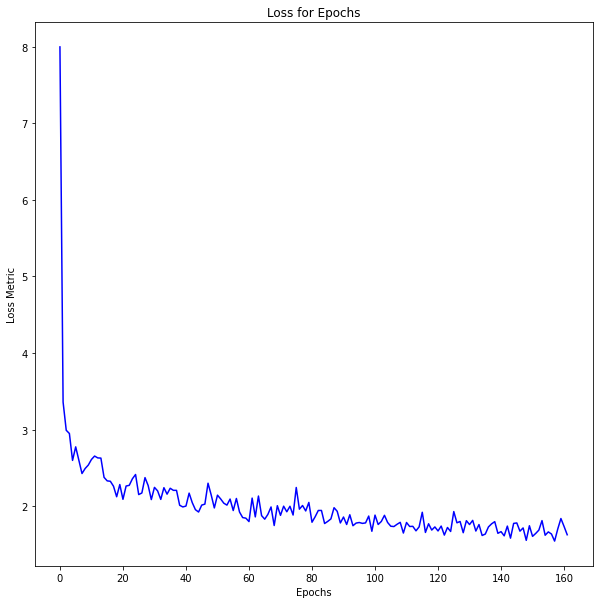

In [ ]:
def plot_loss(path, mod=1265):
    Y = []
    with open(path, 'r') as f:
        lines = f.readlines()
        num_epochs = len(lines)

        for i, line in enumerate(lines):
            if i/mod > 200:
              break
            if i > 100000 and i < 150000: # a crash occured in training
              continue
            if i % mod == 0:
                line = line.strip('\n')
                line_stat = float(line)
                Y.append(line_stat)

            
    plt.rcParams["figure.figsize"] = (10, 10)

    x = [j for j in range(len(Y))] 


    plt.title('Loss for Epochs')
    plt.xlabel('Epochs')
    plt.ylabel('Loss Metric')
    plt.plot(x, Y, 'b')
    plt.show()

plot_loss('/content/drive/My Drive/Vision2/lab3-4/stats.txt')

# BLEU class to calculate the metric

In [ ]:
import sys
import os
import io
import math
from collections import Counter

class BLEUCalculator():
	""" Calculates BLEU metric for MT """
	
	def __init__(self):
		self.candidate = None
		self.references = None
		self.N = 4
		self.output_file_name = '/content/drive/My Drive/Vision2/lab3-4/bleu_out.txt'

	def main(self, args):
		self.load_files(args[0], args[1])
		BLEU_score = self.calculate_BLEU_score()
		self.write_file(BLEU_score)

	def load_files(self, candidate_file, reference_path='/content/drive/My Drive/Vision2/lab3-4/ref.txt'):
		reference_files = []
		if(os.path.isfile(reference_path)):
			reference_files.append(list(io.open(reference_path, encoding='utf-8')))
		else:
			reference_file_dir = reference_path
			for f, file in enumerate(os.listdir(reference_path)):
				reference_filename = reference_path + '/' + file
				reference_files.append(list(io.open(reference_filename, encoding='utf-8')))

		self.references = reference_files
		self.candidate = list(io.open(candidate_file, encoding='utf-8'))

		
	def calculate_BLEU_score(self):
		BP = self.calculate_brevity_penalty()
		pn_term = self.calculate_weighted_pn_sum()

		BLEU_score = BP * math.exp(pn_term)

		print "------------------------"
		print "BLEU: " + str(BLEU_score)
		print "------------------------"
		return BLEU_score

	def calculate_brevity_penalty(self):
		BP = 0; c = 0; r = 0;
		for l_no, candidate_line in enumerate(self.candidate):
			candidate_length = len(self.clean_read_words(candidate_line))

			reference_lengths = []
			for ref_file_no, reference in enumerate(self.references):
				reference_lengths.append(len(self.clean_read_words(reference[l_no])))

			effective_reference_length = min(reference_lengths, key=lambda x:abs(x-candidate_length))
			r += effective_reference_length
			c += candidate_length


		if(c > r):
			BP = 1
		else:
			BP = math.exp(1 - float(r)/float(c))
		
	
		print "BP: " + str(BP)
		
		return BP

	def calculate_weighted_pn_sum(self):
		weighted_pn_sum = 0
		
		wn = 1.0/float(self.N)
		for n in range(1, self.N + 1):
			pn = self.calculate_modified_pn(n)
			if(pn != 0):
				weighted_pn_sum += (wn * math.log(pn), wn) [pn == 0]

		return weighted_pn_sum

	def calculate_modified_pn(self, n):
		
		clipped_count_sum = 0
		candidate_n_grams_count_sum = 0
		
		for l_no, line in enumerate(self.references[0]):
			ref_ngram_counts = self.get_max_ref_count(n, l_no)
			clipped_count, candidate_n_grams_count = self.calculate_clipped_count_sum(l_no, ref_ngram_counts, n)	
			clipped_count_sum += clipped_count
			candidate_n_grams_count_sum += candidate_n_grams_count

		modified_pn = float(clipped_count_sum) / float(candidate_n_grams_count_sum)
		print "P(" + str(n) + ") = " + str(clipped_count_sum) + "/" + str(candidate_n_grams_count_sum) + " = " + str(modified_pn)
		return modified_pn
	
	def get_ngrams(self, n, line):
		ngrams = []
		words = self.clean_read_words(line)
		for i in range(0, len(words) - n + 1):
			if(n <= len(words)):
				ngrams.append(' '.join(str(w.encode('utf-8')) for w in words[i:i+n]))
		return ngrams

	def calculate_clipped_count_sum(self, l_no, ref_ngram_counts, n):
		clipped_count_sum = 0
		line = self.candidate[l_no]
		words = self.clean_read_words(line)
		max_ngram_count = len(words) - n + 1

		ngram_counts = {}
		ngrams = self.get_ngrams(n, line)
		for g, ngram in enumerate(ngrams):
			ngram_counts[ngram] = ngrams.count(ngram)

		ngram_counts = Counter(ngrams)
		
		for g, ngram in enumerate(ngram_counts.keys()):
			count = ngram_counts.get(ngram)
			max_ref_count = (ref_ngram_counts.get(ngram), 0)[ref_ngram_counts.get(ngram) == None]
			clipped_count_sum += min(count, max_ref_count)

		return clipped_count_sum, max_ngram_count

	def get_max_ref_count(self, n, l_no):
		ref_ngram_counts = {}
		for ref_file_no, reference in enumerate(self.references):
			line = reference[l_no]
			words = self.clean_read_words(reference[l_no])
			ngrams = self.get_ngrams(n, line)
			for g, ngram in enumerate(ngrams):
				count = ref_ngram_counts.get(ngram)
				if(count == None):
					count = 1
				ref_ngram_counts[ngram] = max(count, ngrams.count(ngram))
		return ref_ngram_counts

	def write_file(self, BLEU_score):
		output_file = open(self.output_file_name, 'w')
		output_file.write(str(BLEU_score))
		output_file.close()

	def clean_read_words(self, line):
		return self.clean_read(line).split()

	def clean_read(self, line):
		return line.lower().strip()

if __name__ == '__main__':
	BLEUCalculator().main(sys.argv[1:])

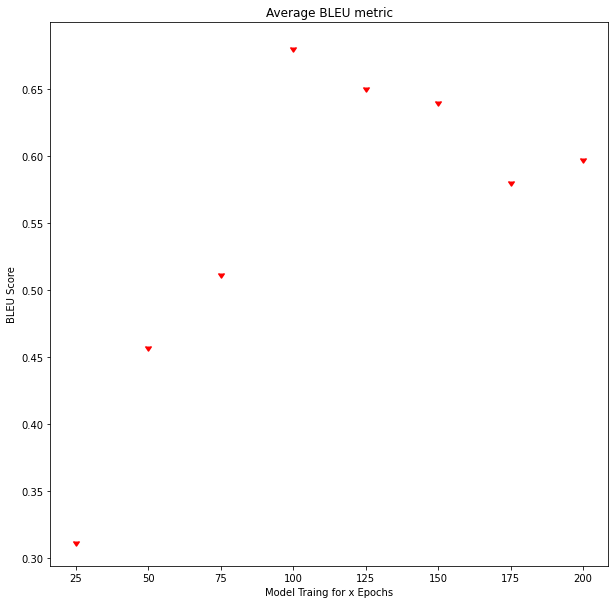

In [50]:
bleu_calc = BLEUCalculator()
BLEU_results_paths = ['/content/drive/My Drive/Vision2/lab3-4/bleu_out25.txt', '/content/drive/My Drive/Vision2/lab3-4/bleu_out50.txt', 
                      '/content/drive/My Drive/Vision2/lab3-4/bleu_out75.txt','/content/drive/My Drive/Vision2/lab3-4/bleu_out100.txt','/content/drive/My Drive/Vision2/lab3-4/bleu_out125.txt',
                      '/content/drive/My Drive/Vision2/lab3-4/bleu_out150.txt','/content/drive/My Drive/Vision2/lab3-4/bleu_out175.txt','/content/drive/My Drive/Vision2/lab3-4/bleu_out200.txt']
step = 25
x = [i*25 for i in range(1,8)] # for each model 
y = [] # average BLEU for each model
j = 0
for i in range(step, 200, step):
  step = load_checkpoint(torch.load(saved_weights_path + "my_checkpoint" + str(i) + ".pth.tar"), model, optimizer, sched)
  model.eval()
  with open(BLEU_results_paths[j], 'r+') as results:
  j += 1
      for (imgs, captions) in train_loader:
          i = 0
          for img in imgs:
              img = img.unsqueeze(0).to(device)
              cap = model.caption_image(img, dataset.vocab)
              results.write(f'{cap}')
      bleu_calc.load_files(BLEU_results_paths[j])  
      y.append(bleu_calc.calculate_BLEU_score())

plt.plot(x, y, color='red', marker=11)
plt.title('Average BLEU metric per model')
plt.xlabel('Model Training for x Epochs')
plt.xlabel('BLEU score')
plt.show()